# Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import AdaBoostRegressor, VotingRegressor, IsolationForest, RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from math import pow
from scipy.stats import ttest_ind

# Obtain Data

Read csv with salary data into pandas

In [ ]:
salary_df = pd.read_csv('../salary.csv')
print('salary_df Shape: ', salary_df.shape)
salary_df.head()

salary_df Shape:  (576, 3)


,Player,Salary,Inflation Adjusted Salary
0,Stephen Curry,"$37,457,154","$38,320,489"
1,Russell Westbrook,"$35,665,000","$36,487,029"
2,Chris Paul,"$35,654,150","$36,475,929"
3,LeBron James,"$35,654,150","$36,475,929"
4,Kyle Lowry,"$32,700,000","$33,453,690"


Read csv with player stats into pandas

In [ ]:
stats_df = pd.read_csv('../player_stats.csv')
print('stats_df Shape: ', stats_df.shape)
stats_df.head()

stats_df Shape:  (530, 29)


,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,Álex Abrines,SG,25,OKC,31,2,588,56,157,0.357,41,127,0.323,15,30,0.500,0.487,12,13,0.923,5,43,48,20,17,6,14,53,165
1,Quincy Acy,PF,28,PHO,10,0,123,4,18,0.222,2,15,0.133,2,3,0.667,0.278,7,10,0.700,3,22,25,8,1,4,4,24,17
2,Jaylen Adams,PG,22,ATL,34,1,428,38,110,0.345,25,74,0.338,13,36,0.361,0.459,7,9,0.778,11,49,60,65,14,5,28,45,108
3,Steven Adams,C,25,OKC,80,80,2669,481,809,0.595,0,2,0.000,481,807,0.596,0.595,146,292,0.500,391,369,760,124,117,76,135,204,1108
4,Bam Adebayo,C,21,MIA,82,28,1913,280,486,0.576,3,15,0.200,277,471,0.588,0.579,166,226,0.735,165,432,597,184,71,65,121,203,729


# Scrub Data

Update player names to match across stats_df and salary_df for subsequent merger

In [ ]:
stats_df['Player'] = stats_df['Player'].apply(lambda x: x.replace('.', ''))
stats_df['Player'] = stats_df['Player'].apply(lambda x: x.replace('ć', 'c'))
stats_df['Player'] = stats_df['Player'].apply(lambda x: x.replace('ó', 'o'))
stats_df['Player'] = stats_df['Player'].apply(lambda x: x.replace('č', 'c'))
stats_df['Player'] = stats_df['Player'].apply(lambda x: x.replace('é', 'e'))
stats_df['Player'] = stats_df['Player'].apply(lambda x: x.replace('Á', 'A'))
stats_df['Player'] = stats_df['Player'].apply(lambda x: x.replace('á', 'a'))
stats_df['Player'] = stats_df['Player'].apply(lambda x: x.replace('ā', 'a'))
stats_df['Player'] = stats_df['Player'].apply(lambda x: x.replace('ū', 'u'))
stats_df['Player'] = stats_df['Player'].apply(lambda x: x.replace('Ž', 'Z'))
stats_df['Player'] = stats_df['Player'].apply(lambda x: x.replace('ž', 'z'))
stats_df['Player'] = stats_df['Player'].apply(lambda x: x.replace('š', 's'))
stats_df['Player'] = stats_df['Player'].apply(lambda x: x.replace('Š', 'S'))
stats_df['Player'] = stats_df['Player'].apply(lambda x: x.replace('ý', 'y'))
stats_df['Player'] = stats_df['Player'].apply(lambda x: x.replace('ö', 'oe'))
stats_df['Player'] = stats_df['Player'].apply(lambda x: x.replace('è', 'e'))
stats_df['Player'] = stats_df['Player'].apply(lambda x: x.replace('İ', 'I'))
stats_df['Player'] = stats_df['Player'].apply(lambda x: x.replace('í', 'i'))
stats_df['Player'] = stats_df['Player'].apply(lambda x: x.replace("' ", ' '))
stats_df['Player'] = stats_df['Player'].apply(lambda x: x.replace(' III', ''))
salary_df['Player'] = salary_df['Player'].apply(lambda x: x.replace(' III', ''))
stats_df['Player'] = stats_df['Player'].apply(lambda x: x.replace(' Jr', ''))
salary_df['Player'] = salary_df['Player'].apply(lambda x: x.replace(' Jr', ''))
stats_df['Player'] = stats_df['Player'].apply(lambda x: x.replace('JJ Barea', 'Jose Juan Barea'))
stats_df['Player'] = stats_df['Player'].apply(lambda x: x.replace('Vince Edwards', 'Vincent Edwards'))
stats_df['Player'] = stats_df['Player'].apply(lambda x: x.replace('Maurice Harkless', 'Moe Harkless'))
stats_df['Player'] = stats_df['Player'].apply(lambda x: x.replace('Walt Lemon', 'Walter Lemon'))
stats_df['Player'] = stats_df['Player'].apply(lambda x: x.replace('Timothe Luwawu-Cabarrot', 'Timothe Luwawu'))
stats_df['Player'] = stats_df['Player'].apply(lambda x: x.replace('Patty Mills', 'Patrick Mills'))
stats_df['Player'] = stats_df['Player'].apply(lambda x: x.replace('Naz Mitrou-Long', 'Naz Long'))
stats_df['Player'] = stats_df['Player'].apply(lambda x: x.replace('Svi Mykhailiuk', 'Sviatoslav Mykhailiuk'))
stats_df['Player'] = stats_df['Player'].apply(lambda x: x.replace('Cameron Reynolds', 'Cam Reynolds'))
stats_df['Player'] = stats_df['Player'].apply(lambda x: x.replace('Ish Smith', 'Ishmael Smith'))
stats_df['Player'] = stats_df['Player'].apply(lambda x: x.replace('Ray Spalding', 'Raymond Spalding'))
stats_df['Player'] = stats_df['Player'].apply(lambda x: x.replace('Lou Williams', 'Louis Williams'))



Merge stats_df and salary df on player namaes

In [ ]:
df = pd.merge(salary_df, stats_df, on='Player')
print('df Shape: ', df.shape)
df.head()

df Shape:  (530, 31)


,Player,Salary,Inflation Adjusted Salary,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,Stephen Curry,"$37,457,154","$38,320,489",PG,30,GSW,69,69,2331,632,1340,0.472,354,810,0.437,278,530,0.525,0.604,263,287,0.916,45,324,369,361,92,25,192,166,1881
1,Russell Westbrook,"$35,665,000","$36,487,029",PG,30,OKC,73,73,2630,630,1473,0.428,119,411,0.290,511,1062,0.481,0.468,296,451,0.656,109,698,807,784,142,33,325,245,1675
2,Chris Paul,"$35,654,150","$36,475,929",PG,33,HOU,58,58,1857,302,720,0.419,127,355,0.358,175,365,0.479,0.508,175,203,0.862,36,229,265,473,114,18,152,146,906
3,LeBron James,"$35,654,150","$36,475,929",SF,34,LAL,55,55,1937,558,1095,0.510,111,327,0.339,447,768,0.582,0.560,278,418,0.665,57,408,465,454,72,33,197,94,1505
4,Kyle Lowry,"$32,700,000","$33,453,690",PG,32,TOR,65,65,2213,304,739,0.411,157,453,0.347,147,286,0.514,0.518,161,194,0.830,41,271,312,564,91,31,182,166,926


View what scrubbing needed with df.info()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 530 entries, 0 to 529
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Player                     530 non-null    object 
 1   Salary                     530 non-null    object 
 2   Inflation Adjusted Salary  530 non-null    object 
 3   Pos                        530 non-null    object 
 4   Age                        530 non-null    int64  
 5   Tm                         530 non-null    object 
 6   G                          530 non-null    int64  
 7   GS                         530 non-null    int64  
 8   MP                         530 non-null    int64  
 9   FG                         530 non-null    int64  
 10  FGA                        530 non-null    int64  
 11  FG%                        526 non-null    float64
 12  3P                         530 non-null    int64  
 13  3PA                        530 non-null    int64  

Drop columns not useful for modeling

In [ ]:
df.drop(columns=['Player', 'Inflation Adjusted Salary', 'Tm', 'TRB'], inplace=True)
print('df Shape: ', df.shape)
df.head()

df Shape:  (530, 27)


,Salary,Pos,Age,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,AST,STL,BLK,TOV,PF,PTS
0,"$37,457,154",PG,30,69,69,2331,632,1340,0.472,354,810,0.437,278,530,0.525,0.604,263,287,0.916,45,324,361,92,25,192,166,1881
1,"$35,665,000",PG,30,73,73,2630,630,1473,0.428,119,411,0.290,511,1062,0.481,0.468,296,451,0.656,109,698,784,142,33,325,245,1675
2,"$35,654,150",PG,33,58,58,1857,302,720,0.419,127,355,0.358,175,365,0.479,0.508,175,203,0.862,36,229,473,114,18,152,146,906
3,"$35,654,150",SF,34,55,55,1937,558,1095,0.510,111,327,0.339,447,768,0.582,0.560,278,418,0.665,57,408,454,72,33,197,94,1505
4,"$32,700,000",PG,32,65,65,2213,304,739,0.411,157,453,0.347,147,286,0.514,0.518,161,194,0.830,41,271,564,91,31,182,166,926


Update salary to int data type and divide by 1,000,000

In [ ]:
df['Salary'] = df['Salary'].apply(lambda x: int(x.replace('$', '').replace(',', '')))
df['Salary'] = df['Salary']/1000000
df.rename(columns={'Salary': 'Salary(In Millions)'})
df.head()

,Salary,Pos,Age,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,AST,STL,BLK,TOV,PF,PTS
0,37.457154,PG,30,69,69,2331,632,1340,0.472,354,810,0.437,278,530,0.525,0.604,263,287,0.916,45,324,361,92,25,192,166,1881
1,35.665000,PG,30,73,73,2630,630,1473,0.428,119,411,0.290,511,1062,0.481,0.468,296,451,0.656,109,698,784,142,33,325,245,1675
2,35.654150,PG,33,58,58,1857,302,720,0.419,127,355,0.358,175,365,0.479,0.508,175,203,0.862,36,229,473,114,18,152,146,906
3,35.654150,SF,34,55,55,1937,558,1095,0.510,111,327,0.339,447,768,0.582,0.560,278,418,0.665,57,408,454,72,33,197,94,1505
4,32.700000,PG,32,65,65,2213,304,739,0.411,157,453,0.347,147,286,0.514,0.518,161,194,0.830,41,271,564,91,31,182,166,926


Update position (Pos) for multipositional nba players to their predominant position

In [ ]:
df['Pos'] = df['Pos'].apply(lambda x: x.split('-')[0])
df['Pos'].value_counts()

SG    134
PF    107
PG    107
C      95
SF     87
Name: Pos, dtype: int64

Create dummy variable for position feature

In [ ]:
df = pd.get_dummies(df, columns=['Pos'], drop_first=True, prefix_sep=': ')
df.head()

,Salary,Age,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,AST,STL,BLK,TOV,PF,PTS,Pos: PF,Pos: PG,Pos: SF,Pos: SG
0,37.457154,30,69,69,2331,632,1340,0.472,354,810,0.437,278,530,0.525,0.604,263,287,0.916,45,324,361,92,25,192,166,1881,0,1,0,0
1,35.665000,30,73,73,2630,630,1473,0.428,119,411,0.290,511,1062,0.481,0.468,296,451,0.656,109,698,784,142,33,325,245,1675,0,1,0,0
2,35.654150,33,58,58,1857,302,720,0.419,127,355,0.358,175,365,0.479,0.508,175,203,0.862,36,229,473,114,18,152,146,906,0,1,0,0
3,35.654150,34,55,55,1937,558,1095,0.510,111,327,0.339,447,768,0.582,0.560,278,418,0.665,57,408,454,72,33,197,94,1505,0,0,1,0
4,32.700000,32,65,65,2213,304,739,0.411,157,453,0.347,147,286,0.514,0.518,161,194,0.830,41,271,564,91,31,182,166,926,0,1,0,0


Calculate True Shooting Percentage interaction and drop other shooting features

In [ ]:
df['TS%'] = df['PTS'] / (df['FGA'] + df['FTA']/2) / 2
df.drop(columns=['FG', 'FGA', 'FG%', '3P', '3PA', '3P%','2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%'], 
        inplace=True)
df.head()

,Salary,Age,G,GS,MP,ORB,DRB,AST,STL,BLK,TOV,PF,PTS,Pos: PF,Pos: PG,Pos: SF,Pos: SG,TS%
0,37.457154,30,69,69,2331,45,324,361,92,25,192,166,1881,0,1,0,0,0.633974
1,35.665000,30,73,73,2630,109,698,784,142,33,325,245,1675,0,1,0,0,0.493082
2,35.654150,33,58,58,1857,36,229,473,114,18,152,146,906,0,1,0,0,0.551430
3,35.654150,34,55,55,1937,57,408,454,72,33,197,94,1505,0,0,1,0,0.577071
4,32.700000,32,65,65,2213,41,271,564,91,31,182,166,926,0,1,0,0,0.553828


Replace missing TS% values with 0 corresponding to players lack of a field goal attempt

In [ ]:
df.fillna(value=0, inplace=True)
df.head()

,Salary,Age,G,GS,MP,ORB,DRB,AST,STL,BLK,TOV,PF,PTS,Pos: PF,Pos: PG,Pos: SF,Pos: SG,TS%
0,37.457154,30,69,69,2331,45,324,361,92,25,192,166,1881,0,1,0,0,0.633974
1,35.665000,30,73,73,2630,109,698,784,142,33,325,245,1675,0,1,0,0,0.493082
2,35.654150,33,58,58,1857,36,229,473,114,18,152,146,906,0,1,0,0,0.551430
3,35.654150,34,55,55,1937,57,408,454,72,33,197,94,1505,0,0,1,0,0.577071
4,32.700000,32,65,65,2213,41,271,564,91,31,182,166,926,0,1,0,0,0.553828


Update in game statistics from season totals to per minute

In [ ]:
per_minute_list = ['PTS', 'PF', 'TOV', 'BLK', 'STL', 'AST', 'DRB', 'ORB']
for var in per_minute_list:
    df[f'{var}/M'] = df[var] / df['MP']
df.drop(columns=per_minute_list, inplace=True)
df.head()

,Salary,Age,G,GS,MP,Pos: PF,Pos: PG,Pos: SF,Pos: SG,TS%,PTS/M,PF/M,TOV/M,BLK/M,STL/M,AST/M,DRB/M,ORB/M
0,37.457154,30,69,69,2331,0,1,0,0,0.633974,0.806950,0.071214,0.082368,0.010725,0.039468,0.154869,0.138996,0.019305
1,35.665000,30,73,73,2630,0,1,0,0,0.493082,0.636882,0.093156,0.123574,0.012548,0.053992,0.298099,0.265399,0.041445
2,35.654150,33,58,58,1857,0,1,0,0,0.551430,0.487884,0.078621,0.081852,0.009693,0.061389,0.254712,0.123317,0.019386
3,35.654150,34,55,55,1937,0,0,1,0,0.577071,0.776975,0.048529,0.101704,0.017037,0.037171,0.234383,0.210635,0.029427
4,32.700000,32,65,65,2213,0,1,0,0,0.553828,0.418437,0.075011,0.082241,0.014008,0.041121,0.254858,0.122458,0.018527


Calculate Minutes/Game feature and drop Minutes Played

In [ ]:
df['M/G'] = df['MP']/df['G']
df.drop(columns='MP', inplace=True)
df.head()

,Salary,Age,G,GS,Pos: PF,Pos: PG,Pos: SF,Pos: SG,TS%,PTS/M,PF/M,TOV/M,BLK/M,STL/M,AST/M,DRB/M,ORB/M,M/G
0,37.457154,30,69,69,0,1,0,0,0.633974,0.806950,0.071214,0.082368,0.010725,0.039468,0.154869,0.138996,0.019305,33.782609
1,35.665000,30,73,73,0,1,0,0,0.493082,0.636882,0.093156,0.123574,0.012548,0.053992,0.298099,0.265399,0.041445,36.027397
2,35.654150,33,58,58,0,1,0,0,0.551430,0.487884,0.078621,0.081852,0.009693,0.061389,0.254712,0.123317,0.019386,32.017241
3,35.654150,34,55,55,0,0,1,0,0.577071,0.776975,0.048529,0.101704,0.017037,0.037171,0.234383,0.210635,0.029427,35.218182
4,32.700000,32,65,65,0,1,0,0,0.553828,0.418437,0.075011,0.082241,0.014008,0.041121,0.254858,0.122458,0.018527,34.046154


Confirm data now scrubbed with df.info()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 530 entries, 0 to 529
Data columns (total 18 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Salary   530 non-null    float64
 1   Age      530 non-null    int64  
 2   G        530 non-null    int64  
 3   GS       530 non-null    int64  
 4   Pos: PF  530 non-null    uint8  
 5   Pos: PG  530 non-null    uint8  
 6   Pos: SF  530 non-null    uint8  
 7   Pos: SG  530 non-null    uint8  
 8   TS%      530 non-null    float64
 9   PTS/M    530 non-null    float64
 10  PF/M     530 non-null    float64
 11  TOV/M    530 non-null    float64
 12  BLK/M    530 non-null    float64
 13  STL/M    530 non-null    float64
 14  AST/M    530 non-null    float64
 15  DRB/M    530 non-null    float64
 16  ORB/M    530 non-null    float64
 17  M/G      530 non-null    float64
dtypes: float64(11), int64(3), uint8(4)
memory usage: 64.2 KB


# Explore Data

Build Isolation Forest model to find dataset outliers

In [ ]:
if_x = df.drop(columns=['Salary'])
if_y = df['Salary']
if_x_train, if_x_test, if_y_train, if_y_test = train_test_split(if_x, if_y, random_state=73, test_size=.33)

if_ss = StandardScaler()
if_ss.fit(if_x_train)
ss_if_x_train = pd.DataFrame(if_ss.transform(if_x_train), columns=if_x_train.columns)

isf = IsolationForest(contamination=.0275)
ss_if_x_train['Outlier'] = isf.fit_predict(ss_if_x_train)
ss_if_x_train[ss_if_x_train['Outlier']==-1].round(1)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"


,Age,G,GS,Pos: PF,Pos: PG,Pos: SF,Pos: SG,TS%,PTS/M,PF/M,TOV/M,BLK/M,STL/M,AST/M,DRB/M,ORB/M,M/G,Outlier
14,0.0,-1.8,-0.8,1.9,-0.5,-0.4,-0.6,0.7,1.9,-0.5,-0.5,-1.0,0.3,0.4,6.6,1.7,-1.6,-1
57,0.0,-1.9,-0.8,-0.5,2.0,-0.4,-0.6,1.6,1.9,0.8,0.4,2.1,7.0,2.8,-1.2,0.2,-1.6,-1
135,-1.5,-1.9,-0.8,-0.5,2.0,-0.4,-0.6,3.0,2.9,-2.5,-2.0,-1.0,-1.4,4.3,0.4,-0.8,-2.0,-1
180,-1.2,-1.9,-0.8,-0.5,-0.5,-0.4,-0.6,-5.2,-2.9,-2.5,-2.0,-1.0,-1.4,-1.6,-2.1,15.1,-2.1,-1
196,-0.2,-1.9,-0.8,-0.5,-0.5,2.4,-0.6,-5.2,-2.9,-2.5,-2.0,-1.0,-1.4,-1.6,0.4,-0.8,-1.5,-1
228,0.0,-1.9,-0.8,1.9,-0.5,-0.4,-0.6,-5.2,-2.9,-2.5,-2.0,-1.0,-1.4,-1.6,0.4,1.9,-2.0,-1
246,1.0,-1.9,-0.8,-0.5,-0.5,2.4,-0.6,-5.2,-2.9,-2.5,-2.0,-1.0,-1.4,-1.6,-2.1,-0.8,-2.1,-1
283,-0.7,-1.9,-0.8,-0.5,2.0,-0.4,-0.6,-5.2,-2.9,-2.5,-2.0,-1.0,-1.4,-1.6,-2.1,-0.8,-2.1,-1
311,0.0,-1.9,-0.8,-0.5,-0.5,-0.4,1.7,-5.2,-2.9,-2.5,7.7,-1.0,9.8,-1.6,-2.1,-0.8,-1.8,-1
312,-0.2,-1.7,-0.8,-0.5,-0.5,-0.4,1.7,-2.0,-0.7,2.3,1.5,-1.0,2.7,3.2,-0.1,-0.0,-1.9,-1


Drop all datapoints with less than or equal to 5 games played due to high variance making this data unmodelable and rebuild Isolation Forest

In [ ]:
df = df[df['G']>5]
df.reset_index(inplace=True, drop=True)
if2_x = df.drop(columns=['Salary'])
if2_y = df['Salary']
if2_x_train, if2_x_test, if2_y_train, if2_y_test = train_test_split(if2_x, if2_y, random_state=73, test_size=.33)

if2_ss = StandardScaler()
if2_ss.fit(if2_x_train)
ss_if2_x_train = pd.DataFrame(if2_ss.transform(if2_x_train), columns=if2_x_train.columns)

isf2 = IsolationForest(contamination=.03)
ss_if2_x_train['Outlier'] = isf2.fit_predict(ss_if2_x_train)
ss_if2_x_train[ss_if2_x_train['Outlier']==-1]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"


,Age,G,GS,Pos: PF,Pos: PG,Pos: SF,Pos: SG,TS%,PTS/M,PF/M,TOV/M,BLK/M,STL/M,AST/M,DRB/M,ORB/M,M/G,Outlier
21,-0.942006,-1.966719,-0.879903,-0.522913,1.912366,-0.435639,-0.574989,-4.662978,-2.453968,0.806575,1.638293,-1.125871,1.169018,1.074561,0.495179,-0.840761,-1.396309,-1
23,-0.942006,-1.836183,-0.879903,1.912366,-0.522913,-0.435639,-0.574989,1.723213,2.069451,1.143816,-0.420054,-0.254698,-2.298525,-1.428406,-1.121238,2.250047,-1.632080,-1
27,2.831807,-1.879695,-0.843474,-0.522913,-0.522913,-0.435639,-0.574989,-2.558943,-0.585027,0.762955,-0.603475,-1.125871,-2.298525,-1.210368,3.145130,-0.093276,-1.480343,-1
53,-1.177870,-1.401062,-0.879903,1.912366,-0.522913,-0.435639,-0.574989,-2.311947,-1.317781,1.832450,2.020064,-0.797958,0.233950,-0.583896,2.115187,1.539959,-1.355602,-1
61,-0.234416,-2.010231,-0.879903,-0.522913,-0.522913,-0.435639,1.739164,-3.132771,-0.734646,2.567236,1.577726,-1.125871,4.531485,3.216469,-0.066394,0.052739,-1.973787,-1
136,-1.649596,-1.575111,-0.879903,1.912366,-0.522913,-0.435639,-0.574989,-0.454908,-0.508998,0.592720,2.661773,-0.279949,4.234528,-0.913962,1.565682,1.716569,-1.867618,-1
148,-1.649596,-1.357550,-0.879903,-0.522913,1.912366,-0.435639,-0.574989,-4.364257,-1.951390,-0.634442,-0.193834,0.819749,3.336233,0.554833,-0.118170,0.930654,-1.705840,-1
228,-1.413733,1.209662,2.070913,-0.522913,1.912366,-0.435639,-0.574989,-0.022020,1.554053,-1.205944,2.969684,-0.776079,-0.137371,3.003139,-0.778498,-0.538132,1.243676,-1
252,-0.942006,-1.705647,-0.879903,1.912366,-0.522913,-0.435639,-0.574989,-3.032351,-1.610442,0.395885,-2.359075,1.610158,-1.124617,-1.415801,1.608242,0.559228,-1.808202,-1
254,-0.470280,0.818054,1.743045,1.912366,-0.522913,-0.435639,-0.574989,1.416228,3.280229,0.066584,2.562762,1.597008,0.632760,1.542419,2.958495,0.705719,1.457966,-1


Replace all features greater than 4 standard deviations from the mean with 4 standard deviations value

In [ ]:
replacement_x = df.drop(columns=['Salary'])
replacement_y = df['Salary']
replacement_x_train, replacement_x_test, replacement_y_train, replacement_y_test = train_test_split(
    replacement_x, replacement_y, random_state=73, test_size=.33)
replacement_train_index = replacement_x_train.index
replacement_test_index = replacement_x_test.index

replacement_ss = StandardScaler()
replacement_ss.fit(replacement_x_train)
replacement_x_train = pd.DataFrame(replacement_ss.transform(replacement_x_train), columns=replacement_x_train.columns)
replacement_x_test = pd.DataFrame(replacement_ss.transform(replacement_x_test), columns=replacement_x_test.columns)

def replace_outliers(row):
    output_row = []
    for val in row.values:
        if val > 4:
            output_row.append(4)
        elif val < -4:
            output_row.append(-4)
        else:
            output_row.append(val)
    return pd.Series(output_row, index=row.index)
            
replacement_x_train = replacement_x_train.apply(replace_outliers, axis=1)
replacement_x_train = pd.DataFrame(replacement_ss.inverse_transform(replacement_x_train), 
                                   columns=replacement_x_train.columns, index=replacement_train_index)

replacement_x_test = replacement_x_test.apply(replace_outliers, axis=1)
replacement_x_test = pd.DataFrame(replacement_ss.inverse_transform(replacement_x_test), 
                                   columns=replacement_x_test.columns, index=replacement_test_index)

df = pd.concat([replacement_x_train, replacement_x_test])
df.sort_index(inplace=True)
df['Salary'] = replacement_y
df.head()

,Age,G,GS,Pos: PF,Pos: PG,Pos: SF,Pos: SG,TS%,PTS/M,PF/M,TOV/M,BLK/M,STL/M,AST/M,DRB/M,ORB/M,M/G,Salary
0,30.0,69.0,69.0,-2.775558e-17,1.000000e+00,0.0,2.775558e-17,0.633974,0.806950,0.071214,0.082368,0.010725,0.039468,0.154869,0.138996,0.019305,33.782609,37.457154
1,30.0,73.0,73.0,-2.775558e-17,1.000000e+00,0.0,2.775558e-17,0.493082,0.636882,0.093156,0.123574,0.012548,0.053992,0.298099,0.265399,0.041445,36.027397,35.665000
2,33.0,58.0,58.0,-2.775558e-17,1.000000e+00,0.0,2.775558e-17,0.551430,0.487884,0.078621,0.081852,0.009693,0.061389,0.254712,0.123317,0.019386,32.017241,35.654150
3,34.0,55.0,55.0,-2.775558e-17,-2.775558e-17,1.0,2.775558e-17,0.577071,0.776975,0.048529,0.101704,0.017037,0.037171,0.234383,0.210635,0.029427,35.218182,35.654150
4,32.0,65.0,65.0,-2.775558e-17,1.000000e+00,0.0,2.775558e-17,0.553828,0.418437,0.075011,0.082241,0.014008,0.041121,0.254858,0.122458,0.018527,34.046154,32.700000


Round boolean variables to whole number to correct rounding issues from replacing outlier values

In [ ]:
for col in df.columns:
  if col.startswith('Pos'):
    df[col] = df[col].apply(lambda x: int(round(x, 0)))
df.head()

,Age,G,GS,Pos: PF,Pos: PG,Pos: SF,Pos: SG,TS%,PTS/M,PF/M,TOV/M,BLK/M,STL/M,AST/M,DRB/M,ORB/M,M/G,Salary
0,30.0,69.0,69.0,0,1,0,0,0.633974,0.806950,0.071214,0.082368,0.010725,0.039468,0.154869,0.138996,0.019305,33.782609,37.457154
1,30.0,73.0,73.0,0,1,0,0,0.493082,0.636882,0.093156,0.123574,0.012548,0.053992,0.298099,0.265399,0.041445,36.027397,35.665000
2,33.0,58.0,58.0,0,1,0,0,0.551430,0.487884,0.078621,0.081852,0.009693,0.061389,0.254712,0.123317,0.019386,32.017241,35.654150
3,34.0,55.0,55.0,0,0,1,0,0.577071,0.776975,0.048529,0.101704,0.017037,0.037171,0.234383,0.210635,0.029427,35.218182,35.654150
4,32.0,65.0,65.0,0,1,0,0,0.553828,0.418437,0.075011,0.082241,0.014008,0.041121,0.254858,0.122458,0.018527,34.046154,32.700000


Plot distribution of dependent variable

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribution of NBA Salary Values')

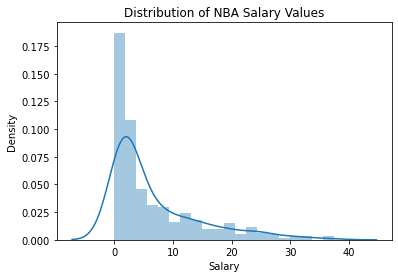

In [ ]:
fig, ax = plt.subplots()
sns.distplot(replacement_y_train, bins=20)
ax.set_title('Distribution of NBA Salary Values')

Log transform Salary dependent variable to reduce the variance caused by the large number of outliers in the long tail distribution of the variable

In [ ]:
df['Salary'] = np.log(df['Salary'])
df.head()

,Age,G,GS,Pos: PF,Pos: PG,Pos: SF,Pos: SG,TS%,PTS/M,PF/M,TOV/M,BLK/M,STL/M,AST/M,DRB/M,ORB/M,M/G,Salary
0,30.0,69.0,69.0,0,1,0,0,0.633974,0.806950,0.071214,0.082368,0.010725,0.039468,0.154869,0.138996,0.019305,33.782609,3.623198
1,30.0,73.0,73.0,0,1,0,0,0.493082,0.636882,0.093156,0.123574,0.012548,0.053992,0.298099,0.265399,0.041445,36.027397,3.574170
2,33.0,58.0,58.0,0,1,0,0,0.551430,0.487884,0.078621,0.081852,0.009693,0.061389,0.254712,0.123317,0.019386,32.017241,3.573866
3,34.0,55.0,55.0,0,0,1,0,0.577071,0.776975,0.048529,0.101704,0.017037,0.037171,0.234383,0.210635,0.029427,35.218182,3.573866
4,32.0,65.0,65.0,0,1,0,0,0.553828,0.418437,0.075011,0.082241,0.014008,0.041121,0.254858,0.122458,0.018527,34.046154,3.487375


Calculate descriptive statistics for each feature

In [ ]:
df.describe().iloc[:,0:10]

,Age,G,GS,Pos: PF,Pos: PG,Pos: SF,Pos: SG,TS%,PTS/M,PF/M
count,487.000000,487.000000,487.00000,487.000000,487.000000,487.000000,487.000000,487.000000,487.000000,487.000000
mean,26.002053,53.361396,25.25462,0.197125,0.203285,0.164271,0.252567,0.534990,0.418564,0.094543
std,4.243852,23.007442,28.29985,0.398237,0.402857,0.370902,0.434931,0.065727,0.131691,0.031983
min,19.000000,6.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.259300,0.092105,0.025641
25%,23.000000,36.000000,1.00000,0.000000,0.000000,0.000000,0.000000,0.503433,0.328328,0.071415
50%,25.000000,59.000000,13.00000,0.000000,0.000000,0.000000,0.000000,0.542400,0.400666,0.088785
75%,29.000000,74.000000,49.00000,0.000000,0.000000,0.000000,1.000000,0.575966,0.496446,0.112490
max,42.000000,82.000000,82.00000,1.000000,1.000000,1.000000,1.000000,0.702703,0.940191,0.229620


In [ ]:
df.describe().iloc[:,11:]

,BLK/M,STL/M,AST/M,DRB/M,ORB/M,M/G,Salary
count,487.000000,4.870000e+02,487.000000,487.000000,487.000000,487.000000,487.000000
mean,0.020305,3.065811e-02,0.092919,0.142391,0.044354,20.422987,1.151748
std,0.017760,1.316705e-02,0.055906,0.060181,0.034499,8.551925,1.524429
min,0.000000,3.469447e-18,0.000000,0.025641,0.000000,3.142857,-2.953248
25%,0.008216,2.156362e-02,0.051453,0.098476,0.018476,13.649123,0.434992
50%,0.014939,2.931596e-02,0.076209,0.128981,0.030612,20.179104,1.198266
75%,0.027014,3.793020e-02,0.124431,0.177343,0.064481,27.434361,2.359578
max,0.087819,8.383490e-02,0.298099,0.344482,0.159804,36.926829,3.623198


Plot distribution for each variable

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

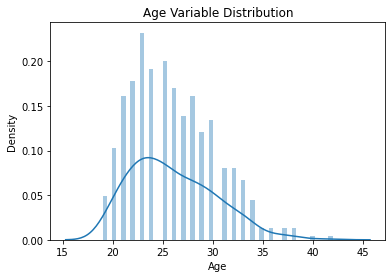

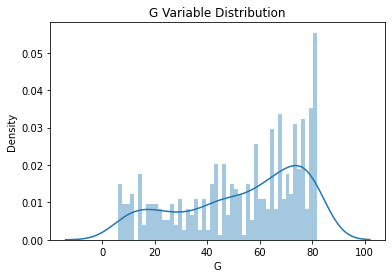

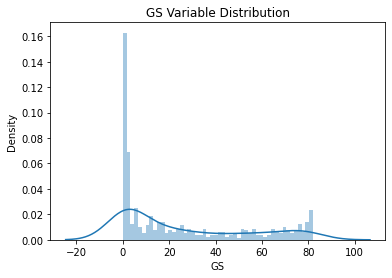

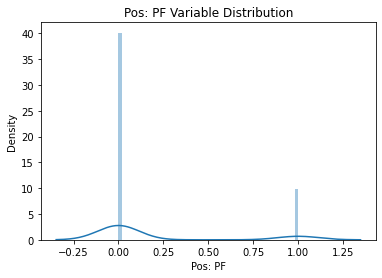

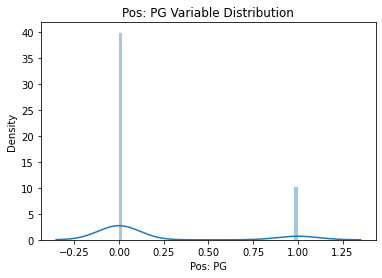

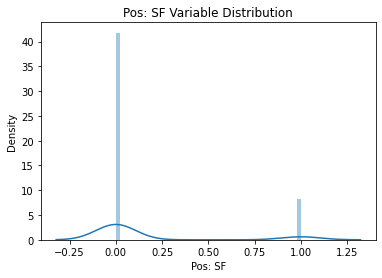

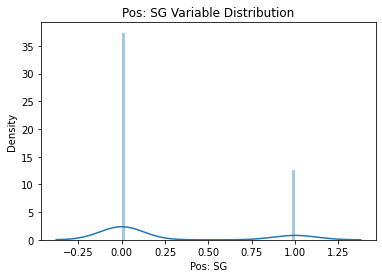

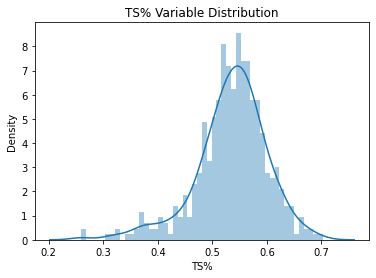

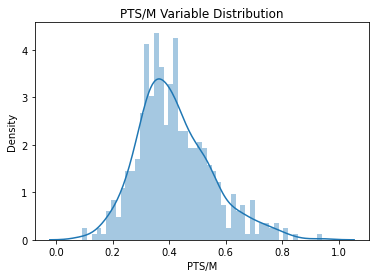

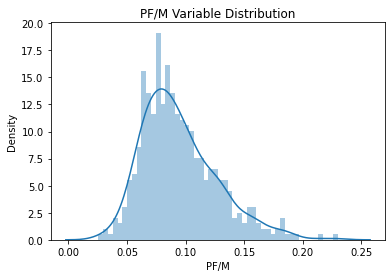

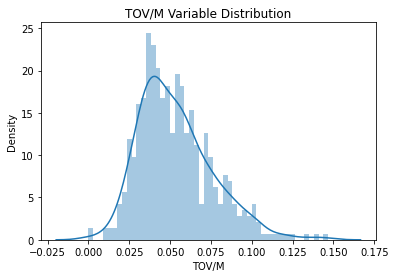

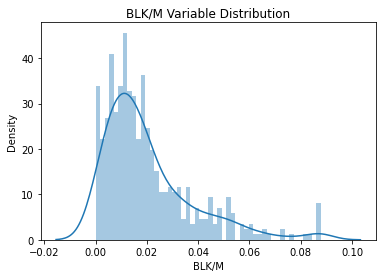

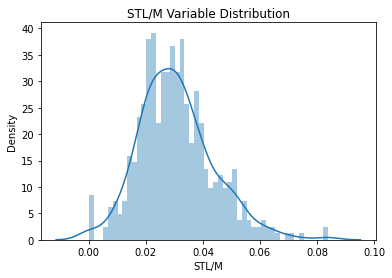

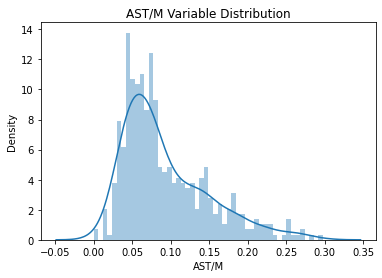

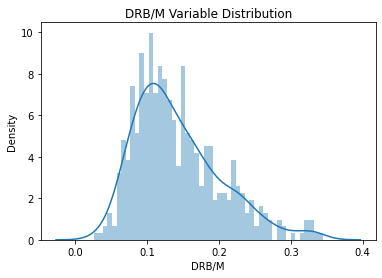

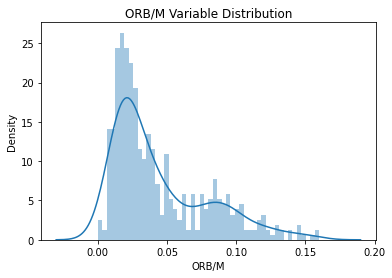

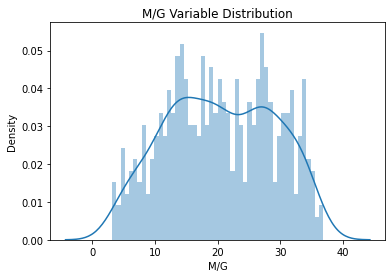

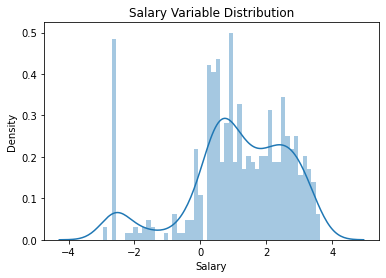

In [ ]:
for feat in df.columns:
    fig, ax = plt.subplots()
    sns.distplot(df[feat], bins=50)
    ax.set_title(f'{feat} Variable Distribution')

Plot relationship between each feature and the Salary dependent varaible

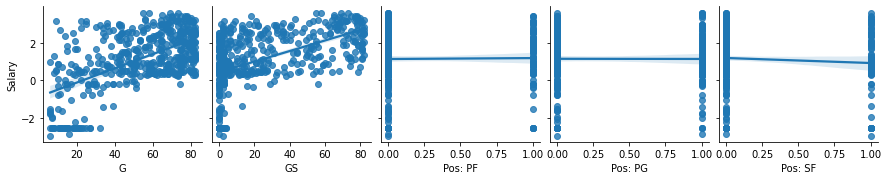

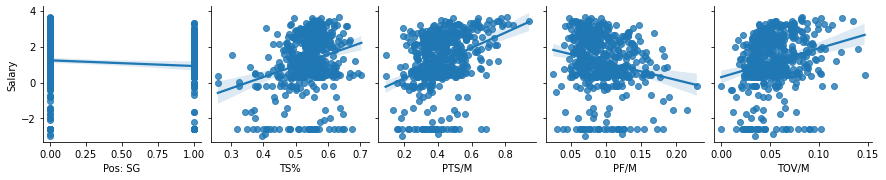

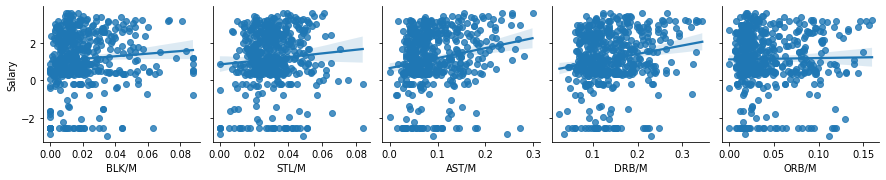

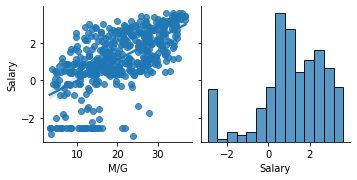

In [ ]:
for num in range(1,len(df.columns), 5):
    pairplot = sns.pairplot(df, x_vars=df.columns[num:num+5], y_vars='Salary', kind='reg')

Calculate correlation of each feature with the dependent variable

In [ ]:
df.corr()[['Salary']].abs().sort_values(by='Salary')

,Salary
Pos: PG,0.002403
Pos: PF,0.012649
ORB/M,0.016500
Pos: SF,0.065348
BLK/M,0.080669
STL/M,0.084986
Pos: SG,0.089556
DRB/M,0.178049
AST/M,0.196822
PF/M,0.200544


Perform t tests to determine if there are statistically significant differences in mean salary between classes for all positional dummy variables

In [ ]:
print('PG t test:', ttest_ind(df[df['Pos: PG']>.5]['Salary'], df[df['Pos: PG']<.5]['Salary']))
print('PF t test:', ttest_ind(df[df['Pos: PF']>.5]['Salary'], df[df['Pos: PF']<.5]['Salary']))
print('SF t test:', ttest_ind(df[df['Pos: SF']>.5]['Salary'], df[df['Pos: SF']<.5]['Salary']))
print('SG t test:', ttest_ind(df[df['Pos: SG']>.5]['Salary'], df[df['Pos: SG']<.5]['Salary']))

PG t test: Ttest_indResult(statistic=-0.05291241251939865, pvalue=0.9578234811035417)
PF t test: Ttest_indResult(statistic=0.27859510833869083, pvalue=0.7806743086399428)
SF t test: Ttest_indResult(statistic=-1.4422164641057085, pvalue=0.14988675116203)
SG t test: Ttest_indResult(statistic=-1.9802157293138263, pvalue=0.048243993295424024)


Drop Pos: PG and Pos: PF due to potential for overfitting to variables with little apparent modeling value

In [ ]:
df.drop(columns=['Pos: PG', 'Pos: PF'], inplace=True)
df.head()

,Age,G,GS,Pos: SF,Pos: SG,TS%,PTS/M,PF/M,TOV/M,BLK/M,STL/M,AST/M,DRB/M,ORB/M,M/G,Salary
0,30.0,69.0,69.0,0,0,0.633974,0.806950,0.071214,0.082368,0.010725,0.039468,0.154869,0.138996,0.019305,33.782609,3.623198
1,30.0,73.0,73.0,0,0,0.493082,0.636882,0.093156,0.123574,0.012548,0.053992,0.298099,0.265399,0.041445,36.027397,3.574170
2,33.0,58.0,58.0,0,0,0.551430,0.487884,0.078621,0.081852,0.009693,0.061389,0.254712,0.123317,0.019386,32.017241,3.573866
3,34.0,55.0,55.0,1,0,0.577071,0.776975,0.048529,0.101704,0.017037,0.037171,0.234383,0.210635,0.029427,35.218182,3.573866
4,32.0,65.0,65.0,0,0,0.553828,0.418437,0.075011,0.082241,0.014008,0.041121,0.254858,0.122458,0.018527,34.046154,3.487375


Calculate feature vif to confirm if features need to be dropped

In [ ]:
vif_x = df.drop(columns=['Salary'])
vif_y = df['Salary']
vif_x_train, vif_x_test, vif_y_train, vif_y_test = train_test_split(vif_x, vif_y, random_state=73, test_size=.33)

vif_df = add_constant(vif_x_train)
vif_output = []
for num in range(0, len(vif_df.columns)):
    vif_output.append([vif_df.columns[num], variance_inflation_factor(vif_df.values, num)])
vif_output_df = pd.DataFrame(vif_output, columns=['Column', 'VIF'])
vif_output_df.sort_values(by='VIF', ascending=False, inplace=True)
vif_output_df.reset_index(drop=True, inplace=True)
vif_output_df.round(1)

,Column,VIF
0,const,148.3
1,M/G,4.6
2,GS,3.1
3,TOV/M,2.5
4,AST/M,2.5
5,PTS/M,2.3
6,G,2.1
7,TS%,1.9
8,PF/M,1.9
9,BLK/M,1.8


Calculate correlation of ORB/M with other features

In [ ]:
df.corr()[['ORB/M']].abs().sort_values(by='ORB/M', ascending=False).drop(index='ORB/M')

,ORB/M
DRB/M,0.679427
BLK/M,0.594577
PF/M,0.449165
Pos: SG,0.356579
AST/M,0.303336
TS%,0.300316
Pos: SF,0.130077
M/G,0.099961
Age,0.083894
PTS/M,0.071060


Drop ORB/M feature due to potential for overfitting to feature with little apparent modeling value and correlation to other features

In [ ]:
df.drop(columns='ORB/M', inplace=True)
df.head()

,Age,G,GS,Pos: SF,Pos: SG,TS%,PTS/M,PF/M,TOV/M,BLK/M,STL/M,AST/M,DRB/M,M/G,Salary
0,30.0,69.0,69.0,0,0,0.633974,0.806950,0.071214,0.082368,0.010725,0.039468,0.154869,0.138996,33.782609,3.623198
1,30.0,73.0,73.0,0,0,0.493082,0.636882,0.093156,0.123574,0.012548,0.053992,0.298099,0.265399,36.027397,3.574170
2,33.0,58.0,58.0,0,0,0.551430,0.487884,0.078621,0.081852,0.009693,0.061389,0.254712,0.123317,32.017241,3.573866
3,34.0,55.0,55.0,1,0,0.577071,0.776975,0.048529,0.101704,0.017037,0.037171,0.234383,0.210635,35.218182,3.573866
4,32.0,65.0,65.0,0,0,0.553828,0.418437,0.075011,0.082241,0.014008,0.041121,0.254858,0.122458,34.046154,3.487375


# Model Data

Create x and y variables

In [ ]:
x = df.drop(columns=['Salary'])
y = df['Salary']

Perform train test split on data

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=73, test_size=.33)

Standard scale data

In [ ]:
ss = StandardScaler()
ss.fit(x_train)
x_train = pd.DataFrame(ss.transform(x_train), columns = x.columns)
x_test = pd.DataFrame(ss.transform(x_test), columns = x.columns)
x_train.head()

,Age,G,GS,Pos: SF,Pos: SG,TS%,PTS/M,PF/M,TOV/M,BLK/M,STL/M,AST/M,DRB/M,M/G
0,-0.234416,-0.965941,-0.807044,-0.435639,1.739164,-0.395873,-1.020621,-0.180307,-1.329225,-0.551750,-0.125296,-1.084489,-1.146826,-0.139531
1,-0.942006,-1.357550,-0.843474,-0.435639,-0.574989,0.769066,-0.258905,2.078406,0.348145,0.927275,-0.163427,-0.571243,0.904410,-1.410797
2,-0.470280,-1.662135,-0.879903,2.295481,-0.574989,-2.730676,-1.450495,-0.994910,-0.866502,-0.827716,-0.574776,-0.868942,0.254975,-0.993523
3,0.944900,0.905078,0.431571,-0.435639,-0.574989,0.881052,0.180104,-0.571471,0.230043,1.823660,-1.799525,-0.698856,-0.843037,0.177478
4,1.416627,-0.835405,-0.661324,-0.435639,-0.574989,-0.214589,-1.032006,2.196491,-0.533290,0.805768,1.490273,-0.792841,0.348439,-0.640339


Build and evaluate Dummy Regressor model

In [ ]:
dr = DummyRegressor(strategy='mean')
dr.fit(x_train, y_train)
y_train_pred_dr = dr.predict(x_train)
y_test_pred_dr = dr.predict(x_test)
print('Dummy Regressor')
print('Train RMSE', np.sqrt(mean_squared_error(y_train, y_train_pred_dr)))
print('Train MAE', mean_absolute_error(y_train, y_train_pred_dr))
print('Train R Squared', r2_score(y_train, y_train_pred_dr))
print('Test RMSE', np.sqrt(mean_squared_error(y_test, y_test_pred_dr)))
print('Test MAE', mean_absolute_error(y_test, y_test_pred_dr))
print('Test R Squared', r2_score(y_test, y_test_pred_dr))

Dummy Regressor
Train RMSE 1.5007309418864851
Train MAE 1.1508328247213726
Train R Squared 0.0
Test RMSE 1.5687469337414708
Test MAE 1.252137174430775
Test R Squared -0.007868686685465365


Build and evaluate Linear Regression model

In [ ]:
lr = LinearRegression()
lr.fit(x_train, y_train)
y_train_pred_lr = lr.predict(x_train)
y_test_pred_lr = lr.predict(x_test)
print('Linear Regression')
print('Train RMSE', np.sqrt(mean_squared_error(y_train, y_train_pred_lr)))
print('Train MAE', mean_absolute_error(y_train, y_train_pred_lr))
print('Train R Squared', r2_score(y_train, y_train_pred_lr))
print('Test RMSE', np.sqrt(mean_squared_error(y_test, y_test_pred_lr)))
print('Test MAE', mean_absolute_error(y_test, y_test_pred_lr))
print('Test R Squared', r2_score(y_test, y_test_pred_lr))

Linear Regression
Train RMSE 0.9778114058763163
Train MAE 0.7706734841489566
Train R Squared 0.5754737748231344
Test RMSE 1.0649502138329991
Test MAE 0.8092190054063826
Test R Squared 0.5355309471565439


Gridsearch Ridge model

In [ ]:
ri_gs_dic = {'alpha': [x/100 for x in range(0000, 1001)]}
ri_gs_model = Ridge(random_state=37)
ri_gs = GridSearchCV(ri_gs_model, ri_gs_dic, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=-1)
ri_gs.fit(x_train, y_train)
print('Ridge Gridsearch')
print('Best Params', ri_gs.best_params_)
print('Best Score', ri_gs.best_score_)

Fitting 5 folds for each of 1001 candidates, totalling 5005 fits
Ridge Gridsearch
Best Params {'alpha': 7.18}
Best Score -1.0705903527043417


Build and evaluate top performing Ridge Model

In [ ]:
ri = Ridge(alpha=7.18, random_state=37)
ri.fit(x_train, y_train)
y_train_pred_ri = ri.predict(x_train)
y_test_pred_ri = ri.predict(x_test)
print('Ridge Regression')
print('Train RMSE', np.sqrt(mean_squared_error(y_train, y_train_pred_ri)))
print('Train MAE', mean_absolute_error(y_train, y_train_pred_ri))
print('Train R Squared', r2_score(y_train, y_train_pred_ri))
print('Test RMSE', np.sqrt(mean_squared_error(y_test, y_test_pred_ri)))
print('Test MAE', mean_absolute_error(y_test, y_test_pred_ri))
print('Test R Squared', r2_score(y_test, y_test_pred_ri))

Ridge Regression
Train RMSE 0.9784466844385212
Train MAE 0.7734874706490077
Train R Squared 0.5749219710353137
Test RMSE 1.0596650516778199
Test MAE 0.8050857556990366
Test R Squared 0.5401296652386989


Gridsearch Lasso model

In [ ]:
la_gs_dic = {'alpha': [x/100000 for x in range(0, 1001)]}
la_gs_model = Lasso(random_state=91)
la_gs = GridSearchCV(la_gs_model, la_gs_dic, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=-1)
la_gs.fit(x_train, y_train)
print('Lasso Gridsearch')
print('Best Params', la_gs.best_params_)
print('Best Score', la_gs.best_score_)

Fitting 5 folds for each of 1001 candidates, totalling 5005 fits
Lasso Gridsearch
Best Params {'alpha': 0.00798}
Best Score -1.0700801498619077


Build and evaluate top performing Lasso model

In [ ]:
la = Lasso(alpha=.00798, random_state=91)
la.fit(x_train, y_train)
y_train_pred_la = la.predict(x_train)
y_test_pred_la = la.predict(x_test)
print('Lasso Regression')
print('Train RMSE', np.sqrt(mean_squared_error(y_train, y_train_pred_la)))
print('Train MAE', mean_absolute_error(y_train, y_train_pred_la))
print('Train R Squared', r2_score(y_train, y_train_pred_la))
print('Test RMSE', np.sqrt(mean_squared_error(y_test, y_test_pred_la)))
print('Test MAE', mean_absolute_error(y_test, y_test_pred_la))
print('Test R Squared', r2_score(y_test, y_test_pred_la))

Lasso Regression
Train RMSE 0.97869976901837
Train MAE 0.7732729179658948
Train R Squared 0.574702041611541
Test RMSE 1.0579783235034963
Test MAE 0.8032997801309731
Test R Squared 0.541592502774576


Gridsearch Elastic Net model

In [ ]:
en_gs_dic = {'alpha': [x/10000 for x in range(70, 171)],
             'l1_ratio': [x/1000 for x in range(500, 601)]}
en_gs_model = ElasticNet(random_state=12)
en_gs = GridSearchCV(en_gs_model, en_gs_dic, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=-1)
en_gs.fit(x_train, y_train)
print('Elastic Net')
print('Best Params', en_gs.best_params_)
print('Best Score', en_gs.best_score_)

Fitting 5 folds for each of 10201 candidates, totalling 51005 fits
Elastic Net
Best Params {'alpha': 0.012, 'l1_ratio': 0.538}
Best Score -1.0700291293642576


Build and evaluate top performing Elastic Net

In [ ]:
en = ElasticNet(alpha=.012, l1_ratio=.538, random_state=12)
en.fit(x_train, y_train)
y_train_pred_en = en.predict(x_train)
y_test_pred_en = en.predict(x_test)
print('Elastic Net')
print('Train RMSE', np.sqrt(mean_squared_error(y_train, y_train_pred_en)))
print('Train MAE', mean_absolute_error(y_train, y_train_pred_en))
print('Train R Squared', r2_score(y_train, y_train_pred_en))
print('Test RMSE', np.sqrt(mean_squared_error(y_test, y_test_pred_en)))
print('Test MAE', mean_absolute_error(y_test, y_test_pred_en))
print('Test R Squared', r2_score(y_test, y_test_pred_en))

Elastic Net
Train RMSE 0.9786225195577505
Train MAE 0.7732326253108711
Train R Squared 0.574769177095439
Test RMSE 1.0578842762732505
Test MAE 0.8034075927278046
Test R Squared 0.541673997902212


Gridsearch Adaboost model

In [ ]:
ab_gs_dic = {'learning_rate': [x/1000 for x in range(0, 1001)]}
ab_gs_model = AdaBoostRegressor(random_state=17)
ab_gs = GridSearchCV(ab_gs_model, ab_gs_dic, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=-1)
ab_gs.fit(x_train, y_train)
print('Adaboost Gridsearch')
print('Best Params', ab_gs.best_params_)
print('Best Score', ab_gs.best_score_)

Fitting 5 folds for each of 1001 candidates, totalling 5005 fits
Adaboost Gridsearch
Best Params {'learning_rate': 0.705}
Best Score -0.9040636174176205


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5005.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_weight_boosting.py", line 1065, in fit
    return super().fit(X, y, sample_weight)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_weight_boosting.py", line 114, in fit
    raise ValueError("learning_rate must be greater than zero")
Val

Build and evaluate top performing Adaboost model

In [ ]:
ab = AdaBoostRegressor(learning_rate=.705, random_state=17)
ab.fit(x_train, y_train)
y_train_pred_ab = ab.predict(x_train)
y_test_pred_ab = ab.predict(x_test)
print('Adaboost')
print('Train RMSE', np.sqrt(mean_squared_error(y_train, y_train_pred_ab)))
print('Train MAE', mean_absolute_error(y_train, y_train_pred_ab))
print('Train R Squared', r2_score(y_train, y_train_pred_ab))
print('Test RMSE', np.sqrt(mean_squared_error(y_test, y_test_pred_ab)))
print('Test MAE', mean_absolute_error(y_test, y_test_pred_ab))
print('Test R Squared', r2_score(y_test, y_test_pred_ab))

Adaboost
Train RMSE 0.7567729303896406
Train MAE 0.6374272462665996
Train R Squared 0.7457122117672321
Test RMSE 0.9943951087965512
Test MAE 0.7977451727635221
Test R Squared 0.5950362668619136


Gridsearch Random Forest model

In [ ]:
rf_gs_dic = {'max_features': [x/100 for x in range(90, 101)],
             'max_samples': [x/100 for x in range(85, 95)],
             'min_samples_split': [x for x in range(10, 20)]}
rf_gs_model = RandomForestRegressor(random_state=39)
rf_gs = GridSearchCV(rf_gs_model, rf_gs_dic, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=-1)
rf_gs.fit(x_train, y_train)
print('Random Forest Gridsearch')
print('Best Params', rf_gs.best_params_)
print('Best Score', rf_gs.best_score_)

Fitting 5 folds for each of 1100 candidates, totalling 5500 fits
Random Forest Gridsearch
Best Params {'max_features': 0.93, 'max_samples': 0.9, 'min_samples_split': 15}
Best Score -0.9298602910518061


Build and evaluate top performing Random Forest model

In [ ]:
rf = RandomForestRegressor(max_features=.93, max_samples=.9, min_samples_split=15, random_state=39)
rf.fit(x_train, y_train)
y_train_pred_rf = rf.predict(x_train)
y_test_pred_rf = rf.predict(x_test)
print('Random Forest')
print('Train RMSE', np.sqrt(mean_squared_error(y_train, y_train_pred_rf)))
print('Train MAE', mean_absolute_error(y_train, y_train_pred_rf))
print('Train R Squared', r2_score(y_train, y_train_pred_rf))
print('Test RMSE', np.sqrt(mean_squared_error(y_test, y_test_pred_rf)))
print('Test MAE', mean_absolute_error(y_test, y_test_pred_rf))
print('Test R Squared', r2_score(y_test, y_test_pred_rf))

Random Forest
Train RMSE 0.6262717317800742
Train MAE 0.479219246871042
Train R Squared 0.8258514171100982
Test RMSE 1.0180199177635045
Test MAE 0.7721021091175941
Test R Squared 0.5755654563887742


Gridsearch XGBoost model

In [ ]:
xgb_gs_dic = {'subsample': [.345, .3475, .35, .3525, .355],
              'colsample_bynode':[.78, .785, .79, .795, .8],
              'learning_rate': [.085, .0875, .09, .0925, .095],
              'reg_lambda': [19.5, 19.75, 20, 20.25, 20.5],
              'gamma': [.13, .135, .14, .145, .15]}
xgb_gs_model = XGBRegressor(random_state=21)
xgb_gs = GridSearchCV(xgb_gs_model, xgb_gs_dic, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=-1)
xgb_gs.fit(x_train, y_train)
print('XGBoost Gridsearch')
print('Best Params', xgb_gs.best_params_)
print('Best Score', xgb_gs.best_score_)

Fitting 5 folds for each of 3125 candidates, totalling 15625 fits
[19:27:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBoost Gridsearch
Best Params {'colsample_bynode': 0.79, 'gamma': 0.145, 'learning_rate': 0.09, 'reg_lambda': 20, 'subsample': 0.35}
Best Score -0.8993150359809036


Build and evaluate top performing XGBoost model

In [ ]:
xgb = XGBRegressor(colsample_bynode=.79, gamma=.145, learning_rate=.09, reg_lambda=20, subsample=0.35, random_state=21)
xgb.fit(x_train, y_train)
y_train_pred_xgb = xgb.predict(x_train)
y_test_pred_xgb = xgb.predict(x_test)
print('XGboost')
print('Train RMSE', np.sqrt(mean_squared_error(y_train, y_train_pred_xgb)))
print('Train MAE', mean_absolute_error(y_train, y_train_pred_xgb))
print('Train R Squared', r2_score(y_train, y_train_pred_xgb))
print('Test RMSE', np.sqrt(mean_squared_error(y_test, y_test_pred_xgb)))
print('Test MAE', mean_absolute_error(y_test, y_test_pred_xgb))
print('Test R Squared', r2_score(y_test, y_test_pred_xgb))

[19:06:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGboost
Train RMSE 0.6793519218837032
Train MAE 0.5116925411163933
Train R Squared 0.7950801907255871
Test RMSE 1.0262834728308623
Test MAE 0.7943058353930373
Test R Squared 0.5686469802579501


Gridsearch linear SVR model

In [ ]:
svr_gs_dic = {'C': [x/100 for x in range(10, 31)], 
              'epsilon': [x/100 for x in range(40, 61)]}
svr_gs_model = SVR(kernel='linear')
svr_gs = GridSearchCV(svr_gs_model, svr_gs_dic, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=-1)
svr_gs.fit(x_train, y_train)
print('SVR')
print('Best Params', svr_gs.best_params_)
print('Best Score', svr_gs.best_score_)

Fitting 5 folds for each of 441 candidates, totalling 2205 fits
SVR
Best Params {'C': 0.2, 'epsilon': 0.48}
Best Score -1.0766991062399323


Build and evaluate top performing linear svr model

In [ ]:
svr = SVR(C=.2, epsilon=.48, kernel='linear')
svr.fit(x_train, y_train)
y_train_pred_svr = svr.predict(x_train)
y_test_pred_svr = svr.predict(x_test)
print('Linear SVR')
print('Train RMSE', np.sqrt(mean_squared_error(y_train, y_train_pred_svr)))
print('Train MAE', mean_absolute_error(y_train, y_train_pred_svr))
print('Train R Squared', r2_score(y_train, y_train_pred_svr))
print('Test RMSE', np.sqrt(mean_squared_error(y_test, y_test_pred_svr)))
print('Test MAE', mean_absolute_error(y_test, y_test_pred_svr))
print('Test R Squared', r2_score(y_test, y_test_pred_svr))

Linear SVR
Train RMSE 0.9991991380667865
Train MAE 0.7671043016895288
Train R Squared 0.5566992891134341
Test RMSE 1.0640471087922383
Test MAE 0.7803033350974511
Test R Squared 0.5363183764263899


Gridsearch Sigmoid SVR model

In [ ]:
ssvr_gs_dic = {'C': [1.062, 1.0625, 1.063, 1.0635, 1.064], 
               'coef0': [.0021, .00215, .0022, .00225, .0023],
              'epsilon': [.54, .541, .542, .543, .544, .545],
               'gamma': [.0418, .0419, .042, .0421, .0422]}
ssvr_gs_model = SVR(kernel='sigmoid')
ssvr_gs = GridSearchCV(ssvr_gs_model, ssvr_gs_dic, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=-1)
ssvr_gs.fit(x_train, y_train)
print('Sigmoid SVR')
print('Best Params', ssvr_gs.best_params_)
print('Best Score', ssvr_gs.best_score_)

Fitting 5 folds for each of 750 candidates, totalling 3750 fits
Sigmoid SVR
Best Params {'C': 1.063, 'coef0': 0.00225, 'epsilon': 0.541, 'gamma': 0.042}
Best Score -1.0808003459281195


Build and evaluate top performing Sigmoid SVR model

In [ ]:
ssvr = SVR(C=1.063, coef0=0.00225, epsilon=0.541, gamma=0.042, kernel='sigmoid')
ssvr.fit(x_train, y_train)
y_train_pred_ssvr = ssvr.predict(x_train)
y_test_pred_ssvr = ssvr.predict(x_test)
print('Sigmoid SVR')
print('Train RMSE', np.sqrt(mean_squared_error(y_train, y_train_pred_ssvr)))
print('Train MAE', mean_absolute_error(y_train, y_train_pred_ssvr))
print('Train R Squared', r2_score(y_train, y_train_pred_ssvr))
print('Test RMSE', np.sqrt(mean_squared_error(y_test, y_test_pred_ssvr)))
print('Test MAE', mean_absolute_error(y_test, y_test_pred_ssvr))
print('Test R Squared', r2_score(y_test, y_test_pred_ssvr))

Sigmoid SVR
Train RMSE 1.0868737024198207
Train MAE 0.8259903870205666
Train R Squared 0.4754915514689194
Test RMSE 1.0968357702870726
Test MAE 0.8325596907392121
Test R Squared 0.5073013377100892


Gridsearch RBF SVR model

In [ ]:
rsvr_gs_dic = {'C': [x/10 for x in range(51, 61)], 
              'epsilon': [x/100 for x in range(75, 85)],
               'gamma': [x/1000 for x in range(25, 35)]}
rsvr_gs_model = SVR(kernel='rbf')
rsvr_gs = GridSearchCV(rsvr_gs_model, rsvr_gs_dic, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=-1)
rsvr_gs.fit(x_train, y_train)
print('RBF SVR')
print('Best Params', rsvr_gs.best_params_)
print('Best Score', rsvr_gs.best_score_)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
RBF SVR
Best Params {'C': 5.7, 'epsilon': 0.8, 'gamma': 0.03}
Best Score -1.0119849592384798


Build and validate top performing RBF SVR model

In [ ]:
rsvr = SVR(C=5.7, epsilon=0.8, gamma=0.03, kernel='rbf')
rsvr.fit(x_train, y_train)
y_train_pred_rsvr = rsvr.predict(x_train)
y_test_pred_rsvr = rsvr.predict(x_test)
print('RBF SVR')
print('Train RMSE', np.sqrt(mean_squared_error(y_train, y_train_pred_rsvr)))
print('Train MAE', mean_absolute_error(y_train, y_train_pred_rsvr))
print('Train R Squared', r2_score(y_train, y_train_pred_rsvr))
print('Test RMSE', np.sqrt(mean_squared_error(y_test, y_test_pred_rsvr)))
print('Test MAE', mean_absolute_error(y_test, y_test_pred_rsvr))
print('Test R Squared', r2_score(y_test, y_test_pred_rsvr))

RBF SVR
Train RMSE 0.7712460472859002
Train MAE 0.6313831360118575
Train R Squared 0.7358928074136757
Test RMSE 1.0520045366631148
Test MAE 0.8337935556419348
Test R Squared 0.5467546076279931


Gridsearch Poly SVR model

In [ ]:
psvr_gs_dic = {'C': [.11, .115, .12, .125, .13, .135, .14, .145, .15], 
               'coef0': [x for x in range(5, 15)],
               'degree': [2],
               'epsilon': [.73, .735, .74, .745, .75],
               'gamma': [.12, .125, .13, .135, .14]}
psvr_gs_model = SVR(kernel='poly')
psvr_gs = GridSearchCV(psvr_gs_model, psvr_gs_dic, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=-1)
psvr_gs.fit(x_train, y_train)
print('Poly SVR')
print('Best Params', psvr_gs.best_params_)
print('Best Score', psvr_gs.best_score_)

Fitting 5 folds for each of 2250 candidates, totalling 11250 fits
Poly SVR
Best Params {'C': 0.13, 'coef0': 9, 'degree': 2, 'epsilon': 0.74, 'gamma': 0.125}
Best Score -1.0151936708513316


Build and evaluate top performing Poly SVR model

In [ ]:
psvr = SVR(C=.13, coef0=9, degree=2, epsilon=0.74, gamma=0.125, kernel='poly')
psvr.fit(x_train, y_train)
y_train_pred_psvr = psvr.predict(x_train)
y_test_pred_psvr = psvr.predict(x_test)
print('Poly SVR')
print('Train RMSE', np.sqrt(mean_squared_error(y_train, y_train_pred_psvr)))
print('Train MAE', mean_absolute_error(y_train, y_train_pred_psvr))
print('Train R Squared', r2_score(y_train, y_train_pred_psvr))
print('Test RMSE', np.sqrt(mean_squared_error(y_test, y_test_pred_psvr)))
print('Test MAE', mean_absolute_error(y_test, y_test_pred_psvr))
print('Test R Squared', r2_score(y_test, y_test_pred_psvr))

Poly SVR
Train RMSE 0.8747801799919547
Train MAE 0.7054401287196974
Train R Squared 0.6602243941751639
Test RMSE 1.0291993670998936
Test MAE 0.8007854984026089
Test R Squared 0.5661923629044667


Build and evaluate Voting Regressor

In [ ]:
vr = VotingRegressor(estimators=[('ab', ab), ('psvr', psvr), ('svr', svr)], weights=[.9, .55, .15])
vr.fit(x_train, y_train)
y_train_pred_vr = vr.predict(x_train)
y_test_pred_vr = vr.predict(x_test)
print('Voting Regressor')
print('Train RMSE', np.sqrt(mean_squared_error(y_train, y_train_pred_vr)))
print('Train MAE', mean_absolute_error(y_train, y_train_pred_vr))
print('Train R Squared', r2_score(y_train, y_train_pred_vr))
print('Test RMSE', np.sqrt(mean_squared_error(y_test, y_test_pred_vr)))
print('Test MAE', mean_absolute_error(y_test, y_test_pred_vr))
print('Test R Squared', r2_score(y_test, y_test_pred_vr))

Voting Regressor
Train RMSE 0.7817607824408155
Train MAE 0.6545219919547669
Train R Squared 0.7286423395813673
Test RMSE 0.954792931564563
Test MAE 0.757487626581261
Test R Squared 0.6266496499081593


# Analyze Results

Calculate Elastic Net feature coefficients

In [ ]:
en_coef_df = pd.DataFrame(en.coef_, index=x_train.columns, columns=['Coefficient']).sort_values(by='Coefficient')
en_coef_df.reset_index(inplace=True)
en_coef_df.rename(columns={'index' : 'Feature'}, inplace=True)
en_coef_df

,Feature,Coefficient
0,AST/M,-0.247091
1,TS%,-0.157522
2,PF/M,-0.086668
3,Pos: SG,-0.052003
4,Pos: SF,-0.040207
5,GS,0.001409
6,PTS/M,0.008713
7,STL/M,0.039922
8,DRB/M,0.075221
9,BLK/M,0.101252


Plot Elastic Net feature coefficients

[Text(0, 0, 'AST/M'),
 Text(0, 0, 'TS%'),
 Text(0, 0, 'PF/M'),
 Text(0, 0, 'Pos: SG'),
 Text(0, 0, 'Pos: SF'),
 Text(0, 0, 'GS'),
 Text(0, 0, 'PTS/M'),
 Text(0, 0, 'STL/M'),
 Text(0, 0, 'DRB/M'),
 Text(0, 0, 'BLK/M'),
 Text(0, 0, 'TOV/M'),
 Text(0, 0, 'G'),
 Text(0, 0, 'Age'),
 Text(0, 0, 'M/G')]

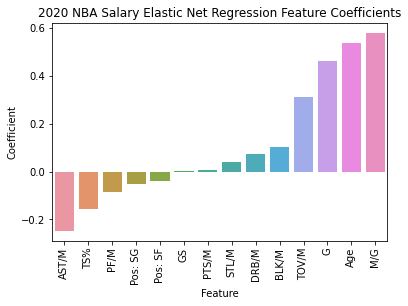

In [ ]:
fig, ax = plt.subplots()
sns.barplot(data=en_coef_df, x='Feature', y='Coefficient', ax=ax)
ax.set_title('2020 NBA Salary Elastic Net Regression Feature Coefficients')
ax.set_xticklabels(en_coef_df['Feature'].values, rotation=90)